# Lab 2: Cardinality Estimation

In [19]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.10.1


In [20]:
def plot_histogram(x):
    plt.figure()
    plt.title('Histogram')
    plt.xlabel('Value')
    plt.ylabel('# of occurence')
    plt.hist(x, bins=20)
    plt.show()

In [21]:
def cardinality(x, lowers, uppers):
    if len(lowers) != len(uppers):
        raise Exception('size of lowers not equal to size of uppers')
    n = len(lowers)
    sel = np.ones(len(x), dtype=bool)
    for i in range(n):
        if lowers[i] != None:
            sel = np.logical_and(sel, x[:, i] >= lowers[i])
        if uppers[i] != None:
            sel = np.logical_and(sel, x[:, i] <= uppers[i])
    return len(sel[np.where(sel == True)])

In [22]:
def generate_training_pairs(x, n_train):
    min_a = np.amin(x[:, 0])
    max_a = np.amax(x[:, 0])
    min_b = np.amin(x[:, 1])
    max_b = np.amax(x[:, 1])
    
    lower_a = np.random.uniform(min_a, max_a, size=n_train)
    upper_a = np.random.uniform(lower_a, max_a, size=n_train)
    lower_a = lower_a.astype(np.int64)
    upper_a = upper_a.astype(np.int64)
    
    lower_b = np.random.uniform(min_b, max_b, size=n_train)
    upper_b = np.random.uniform(lower_b, max_b, size=n_train)
    lower_b = lower_b.astype(np.int64)
    upper_b = upper_b.astype(np.int64)
    
    ranges = np.stack((lower_a, upper_a, lower_b, upper_b), axis=-1)
    cards = []
    for i in range(n_train):
        r = np.resize(ranges[i], (2, 2))
        cards.append(cardinality(x, r[:, 0], r[:, 1]))
    cards = np.array(cards)
    sels = cards.astype(np.float64) / len(x)
    sels = np.expand_dims(sels, 1)
    return ranges, sels

In [23]:
def generate_testing_pairs(x, n_test, scale):
    min_a = np.amin(x[:, 0])
    max_a = np.amax(x[:, 0])
    min_b = np.amin(x[:, 1])
    max_b = np.amax(x[:, 1])
    
    mid_a = np.random.uniform(min_a, max_a, size=n_test)
    interval_a = (max_a - min_a) * scale
    lower_a = np.clip(mid_a - interval_a, min_a, max_a)
    upper_a = np.clip(mid_a + interval_a, min_a, max_a)
    lower_a = lower_a.astype(np.int64)
    upper_a = upper_a.astype(np.int64)
    
    mid_b = np.random.uniform(min_b, max_b, size=n_test)
    interval_b = (max_b - min_b) * scale
    lower_b = np.clip(mid_b - interval_b, min_b, max_b)
    upper_b = np.clip(mid_b + interval_b, min_b, max_b)
    lower_b = lower_b.astype(np.int64)
    upper_b = upper_b.astype(np.int64)
    
    ranges = np.stack((lower_a, upper_a, lower_b, upper_b), axis=-1)
    
    cards = []
    for i in range(n_test):
        r = np.resize(ranges[i], (2, 2))
        cards.append(cardinality(x, r[:, 0], r[:, 1]))
    cards = np.array(cards)
    sels = cards.astype(np.float64) / len(x)
    sels = np.expand_dims(sels, 1)
    return ranges, sels

## Generate the age and the salary data

[[1.         0.99374491]
 [0.99374491 1.        ]]


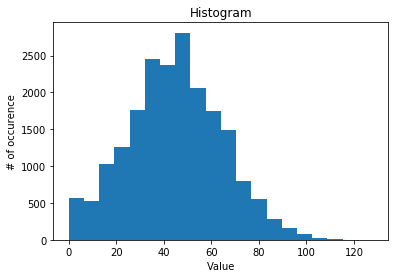

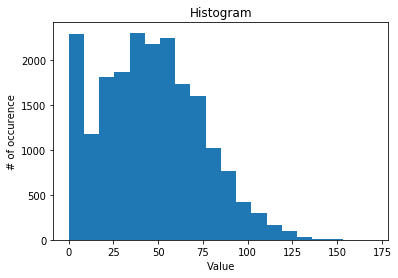

In [30]:
# means and standard deviations of the age and the salary
mean_age = 45
mean_salary = 45
sd_age = 20
sd_salary = 30
#cov = 0
cov = sd_age * sd_salary
x = np.random.multivariate_normal([mean_age, mean_salary], 
                                  [[sd_age ** 2, cov], 
                                   [cov, sd_salary ** 2]], 
                                  size=20000)
x = x.astype(np.int64)
x = np.clip(x, 0, None)
print(np.corrcoef(x.T))
plot_histogram(x[:, 0])
plot_histogram(x[:, 1])

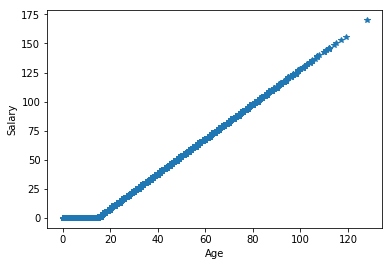

In [31]:
plt.figure()
plt.plot(x[:, 0], x[:, 1], linestyle='None', marker='*')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.show()

## Assume columns are independent

In [32]:
card = cardinality(x, (45, None), (None, None)) * cardinality(x, (None, None), (None, 45))
print('Selectivity under independent-column assumption:')
print(np.float64(card) / (len(x) ** 2))
card = cardinality(x, (45, None), (None, 45))
print('Actual selectivity:')
print(np.float64(card) / len(x))

Selectivity under independent-column assumption:
0.25717032
Actual selectivity:
0.0143


## Generate training pairs

In [34]:
ranges, sels = generate_training_pairs(x, 20000)
print(ranges[0:3])
print(ranges.shape)
print(sels[0:3])
print(sels.shape)

[[103 108  28  29]
 [ 54 104  35  98]
 [ 53  55 130 145]]
(20000, 4)
[[0.    ]
 [0.2872]
 [0.    ]]
(20000, 1)


## Build and train the selectivity estimation model

In [35]:
model = keras.Sequential([
    keras.layers.Dense(1024, activation=tf.nn.sigmoid),
    keras.layers.Dense(32, activation=tf.nn.sigmoid),
    keras.layers.Dense(1)
])

In [36]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='mean_absolute_error',
              metrics=['accuracy'])

In [37]:
ranges_train = ranges[:18000]
sels_train = sels[:18000]
ranges_val = ranges[18000:]
sels_val = sels[18000:]

## Display the training process

In [38]:
history = model.fit(ranges_train, sels_train, validation_data=(ranges_val, sels_val), epochs=10, batch_size=2000)

Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 1s 61us/step - loss: 0.4355 - acc: 0.3712 - val_loss: 0.2354 - val_acc: 0.5350
Epoch 2/10
18000/18000 [==============================] - 0s 24us/step - loss: 0.1348 - acc: 0.5164 - val_loss: 0.1259 - val_acc: 0.5350
Epoch 3/10
18000/18000 [==============================] - 0s 25us/step - loss: 0.0865 - acc: 0.5164 - val_loss: 0.0793 - val_acc: 0.5350
Epoch 4/10
18000/18000 [==============================] - 0s 26us/step - loss: 0.0611 - acc: 0.5164 - val_loss: 0.0439 - val_acc: 0.5350
Epoch 5/10
18000/18000 [==============================] - 0s 25us/step - loss: 0.0448 - acc: 0.5164 - val_loss: 0.0384 - val_acc: 0.5350
Epoch 6/10
18000/18000 [==============================] - 0s 23us/step - loss: 0.0362 - acc: 0.5164 - val_loss: 0.0351 - val_acc: 0.5350
Epoch 7/10
18000/18000 [==============================] - 0s 25us/step - loss: 0.0344 - acc: 0.5164 - val_loss: 0.0326 - val_acc:

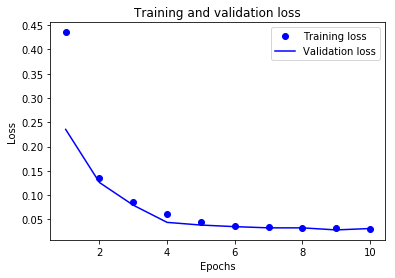

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Make predictions on the training set

In [40]:
preds = model.predict(ranges)
print(sels.shape)
print(preds.shape)
delta = sels - preds
print(np.mean(np.absolute(delta)))

(20000, 1)
(20000, 1)
0.03133172632606269


## Generate the testing set

In [47]:
ranges_test, sels_test = generate_testing_pairs(x, 200, 0.4)

## Make predictions on the testing set

In [48]:
preds_test = model.predict(ranges_test)
delta = sels_test - preds_test
print(np.mean(np.absolute(delta)))

0.08361923830576241


## Evaluate the results

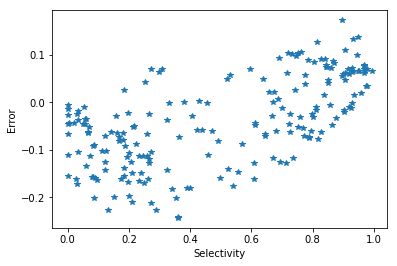

In [49]:
plt.figure()
plt.xlabel('Selectivity')
plt.ylabel('Error')
plt.plot(sels_test, delta, linestyle='None', marker='*')
plt.show()